# Data preparation section

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

In [3]:
import opensmile

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)


In [4]:
import glob

files = glob.glob("../data/raw/RAVDESS/*/*.wav")

In [5]:
file_name_to_emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

##### Data reading and normalisation

In [6]:
speech_data = smile.process_files(files)

In [73]:
normalised_speech_data=(speech_data-speech_data.mean())/speech_data.std()
normalised_speech_data.dropna(axis='columns', inplace=True)

In [74]:
emotion_labels = [file_name_to_emotion_mapping[file.split("-")[-5]] for file in files]

In [77]:
############################## TESTING ##############################
speech_data.to_csv("normalised.csv")

In [125]:
############################## TESTING ##############################
used_columns = normalised_speech_data.columns[:]

##### Splitting the data into training, validation and test sets

In [126]:
from sklearn.model_selection import train_test_split

speeches = normalised_speech_data[used_columns]
emotions = emotion_labels

speeches_train_and_val, speeches_test, emotions_train_and_val, emotions_test = train_test_split(speeches, emotions, test_size=0.2, random_state=42, stratify=emotions)
speeches_train, speeches_val, emotions_train, emotions_val = train_test_split(speeches_train_and_val, emotions_train_and_val, test_size=0.25, random_state=42, stratify=emotions_train_and_val)

In [127]:
print(type(speeches_train))
print(type(speeches_val))
print(type(speeches_test))
print(type(emotions_train))
print(type(emotions_val))
print(type(emotions_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'list'>
<class 'list'>
<class 'list'>


In [128]:
# Pandas dataframes keep the old indexing after sampling, but I need it to be sequential, thus, a reset for the index
speeches_train.reset_index(drop=True, inplace=True)
speeches_val.reset_index(drop=True, inplace=True)
speeches_test.reset_index(drop=True, inplace=True)
# emotions_train.reset_index(drop=True, inplace=True)
# emotions_val.reset_index(drop=True, inplace=True)
# emotions_test.reset_index(drop=True, inplace=True)

In [129]:
from collections import Counter

print(f"{len(speeches_train)=}\t\t{len(emotions_train)=}")
print(f"{len(speeches_val)=}\t\t{len(emotions_val)=}")
print(f"{len(speeches_test)=}\t\t{len(emotions_test)=}")

print(f"{Counter(emotions_train)=}")
print(f"{Counter(emotions_val)=}")
print(f"{Counter(emotions_test)=}")

len(speeches_train)=864		len(emotions_train)=864
len(speeches_val)=288		len(emotions_val)=288
len(speeches_test)=288		len(emotions_test)=288
Counter(emotions_train)=Counter({'calm': 116, 'angry': 115, 'fearful': 115, 'sad': 115, 'happy': 115, 'surprised': 115, 'disgust': 115, 'neutral': 58})
Counter(emotions_val)=Counter({'sad': 39, 'disgust': 39, 'angry': 39, 'calm': 38, 'surprised': 38, 'fearful': 38, 'happy': 38, 'neutral': 19})
Counter(emotions_test)=Counter({'happy': 39, 'fearful': 39, 'surprised': 39, 'sad': 38, 'calm': 38, 'angry': 38, 'disgust': 38, 'neutral': 19})


# Classifier comparison section

##### Building classifiers

In [130]:
from locale import Error
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np

def fit_predict_and_score_classifier(classifier, data_train, data_val, labels_train, labels_val, label_set):
    classifier.fit(data_train, labels_train)
    results = {"train": {}, "val": {}}

    for set_type in ["train", "val"]:
        if set_type == "train":
            data = data_train
            labels = labels_train
        elif set_type == "val":
            data = data_val
            labels = labels_val
        else:
            raise Error("Undefined data set type")

        labels_predicted = classifier.predict(data)

        results[set_type]["predictions"] = labels_predicted
        results[set_type]["accuracy"] = metrics.accuracy_score(labels, labels_predicted)
        results[set_type]["precision"] = metrics.precision_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["recall"] = metrics.recall_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["F1"] = metrics.f1_score(labels, labels_predicted, average="macro", zero_division=1)

    return results

def create_result_table(results):
    first_key = list(results.keys())[0]
    second_key = list(results[first_key].keys())[0]
    table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
    for classifier_name, classifier_data in results.items():
        for set_type, set_metrics in classifier_data.items():
              # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
            new_row = {"Classifier": classifier_name, "Set type": set_type} | set_metrics
            table = table.append(new_row, ignore_index=True)
    return table

def calculate_f1_scores_by_class(labels_predicted, labels):
    all_labels = sorted(list(set(labels)))
    matrix_dimension = range(len(set(labels)))
    matrix = metrics.confusion_matrix(labels, labels_predicted, labels=all_labels)

    recalls = [matrix[index, index] / row_sum for index, row_sum in enumerate(np.sum(matrix, axis=1))]
    precisions = [matrix[index, index] / column_sum for index, column_sum in enumerate(np.sum(matrix, axis=0))]

    f1_scores = {label: {} for label in all_labels}
    for index, label in enumerate(all_labels):
        f1_scores[label] = 2 * (precisions[index] * recalls[index]) / (precisions[index] + recalls[index])

    return f1_scores

In [131]:
# These parameters are repeated, so they are unwrapped while calling functions to reduce clutter
classifier_parameters = (speeches_train, speeches_val, emotions_train, emotions_val, set(emotions))
initial_classifier_results = {}

In [132]:
dummy_classifier_most_frequent = DummyClassifier(strategy="most_frequent")
initial_classifier_results["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *classifier_parameters)

In [133]:
dummy_classifier_stratified = DummyClassifier(strategy="stratified")
initial_classifier_results["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *classifier_parameters)

In [134]:
logistic_regression_one_hot = LogisticRegression()
initial_classifier_results["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression_one_hot, *classifier_parameters)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [135]:
svc_classifier_one_hot = SVC()
initial_classifier_results["svc"] = fit_predict_and_score_classifier(svc_classifier_one_hot, *classifier_parameters)

In [136]:
initial_classifier_results_table = create_result_table(initial_classifier_results)
display(initial_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_18904\837793047.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_18904\837793047.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_18904\837793047.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_18904\837793047.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=Tr

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[angry, happy, angry, calm, surprised, fearful...",0.133102,0.130057,0.131250,0.130314
3,dummy_classifier_stratified,val,"[sad, happy, calm, angry, sad, angry, surprise...",0.142361,0.142167,0.140351,0.140129
4,logistic_regression,train,"[angry, fearful, neutral, sad, happy, surprise...",1.000000,1.000000,1.000000,1.000000
5,logistic_regression,val,"[calm, calm, surprised, sad, fearful, sad, neu...",0.680556,0.684325,0.677716,0.678033
6,svc,train,"[happy, fearful, neutral, sad, happy, surprise...",0.971065,0.968848,0.966436,0.967431
7,svc,val,"[sad, calm, surprised, sad, fearful, sad, neut...",0.604167,0.611779,0.586791,0.585068


In [137]:
f1_scores = calculate_f1_scores_by_class(initial_classifier_results["logistic_regression"]["val"]["predictions"], emotions_val)
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score}")

angry: 0.7397260273972601
calm: 0.7380952380952381
disgust: 0.7500000000000001
fearful: 0.676056338028169
happy: 0.5945945945945946
neutral: 0.6153846153846154
sad: 0.5411764705882353
surprised: 0.7692307692307692


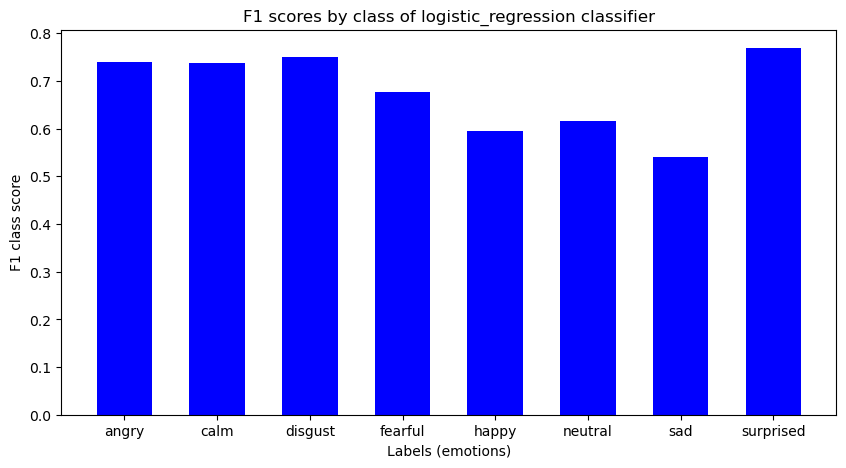

In [138]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions = list(f1_scores.keys())
f1_score_values = list(f1_scores.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions, f1_score_values, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of logistic_regression classifier")
plt.show()